# Import and Load Data

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# Set path to local data directory
folder_path = "additional" 

# Define file paths
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load parquet files (first 30 mins = feature, last 30 mins = target side of the hour)
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')

# Display dataset dimensions and column names
print("Feature DF:", feature_df.shape)
print("Target DF:", target_df.shape)
print("\nFeature columns:", feature_df.columns.tolist())
print("\nTarget columns:", target_df.columns.tolist())

# Concatenating both DataFrames vertically (stacking feature + target rows)
# Note: This doesn't align features and targets — it's just combining both halves of the hour
combined_df = pd.concat([feature_df, target_df], axis=0)

# Sort to organize by stock, time, and within-hour time buckets
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

spy_data = combined_df[combined_df['stock_id'] == 104919]

# Preview top and bottom of the stacked DataFrame
print("\nConcat DF (head):")
display(combined_df.head())

print("\nConcat DF (tail):")
display(combined_df.tail())

Feature DF: (17646119, 11)
Target DF: (17911332, 11)

Feature columns: ['stock_id', 'time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']

Target columns: ['stock_id', 'time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']

Concat DF (head):


,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,8382,6,1800.0,740.03,740.29,740.0,740.30,6,6,800,40
1,8382,6,1800.0,740.03,740.29,740.0,740.30,6,6,800,40
2,8382,6,1801.0,740.05,740.29,740.0,740.30,25,1,99,40
3,8382,6,1801.0,740.05,740.29,740.0,740.30,25,1,99,40
4,8382,6,1802.0,740.06,740.36,740.0,740.39,100,30,399,4



Concat DF (tail):


,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
35557446,104919,1199,3595.0,362.73,362.74,362.72,362.75,200,1190,1200,1600
35557447,104919,1199,3596.0,362.68,362.70,362.67,362.71,800,200,1600,1400
35557448,104919,1199,3597.0,362.69,362.70,362.68,362.71,200,900,1400,1400
35557449,104919,1199,3598.0,362.72,362.73,362.71,362.74,200,1000,900,500
35557450,104919,1199,3599.0,362.80,362.81,362.79,362.82,200,300,600,300


# Feature Engineering

In [14]:
# Apply feature engineering function to the combined DataFrame (includes both first + last 30 min)
def compute_orderbook_features(df):
    """
    Compute engineered order book features from raw order book snapshots.
    """
    df = df.copy()

    # Mid price and Weighted Average Price
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['wap'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (
        df['bid_size1'] + df['ask_size1']
    )

    # Spread and relative spread
    df['bid_ask_spread'] = df['ask_price1'] - df['bid_price1']
    df['spread_pct'] = df['bid_ask_spread'] / df['mid_price']
    df['spread_variation'] = df.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )

    # Spread variation over time within the same time_id
    df['spread_variation'] = df.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )

    # instantaneous returns
    df['log_return']    = np.log(df['wap']).diff()
    df['return_squared']= df['log_return']**2

    df['wap_lag1'] = df.groupby(['stock_id', 'time_id'])['wap'].shift(1)

    df['wap_return'] = (df['wap'] - df['wap_lag1']) / df['wap_lag1']
    df['log_return'] = np.log(df['wap'] / df['wap_lag1'].replace(0, np.nan))
    
    # Order book imbalance and depth ratio
    df['imbalance'] = (df['bid_size1'] - df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['depth_ratio'] = df['bid_size1'] / df['ask_size1'].replace(0, np.nan)

    secs = df['seconds_in_bucket'] % 86400
    df['t_sin'] = np.sin(2*np.pi * secs/86400)
    df['t_cos'] = np.cos(2*np.pi * secs/86400)

    # Return only the engineered features
    keep_cols = [
        'stock_id', 'time_id', 'seconds_in_bucket', 'wap_lag1', 'log_return',
        'wap', 'spread_pct', 'imbalance', 'depth_ratio', 'spread_variation'
    ]
    return df[keep_cols]

# Apply feature engineering to the combined order book data
feature_engineered_df = compute_orderbook_features(combined_df)

def realized_volatility(series):
    return np.sqrt(np.sum(np.square(np.diff(np.log(series)))))

rv = feature_engineered_df.groupby("time_id")["wap"].apply(realized_volatility).reset_index()
rv.columns = ["time_id", "rv"]

time_ref_path = os.path.join(folder_path, "time_id_reference.csv")
time_ref_df = pd.read_csv(time_ref_path)
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])
feature_engineered_df = feature_engineered_df[feature_engineered_df["stock_id"] == 104919].copy()

feature_engineered_df = pd.merge(
    feature_engineered_df.drop(columns=["datetime"], errors="ignore"),  # just in case it already exists
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)

aggregated = feature_engineered_df.groupby("time_id").agg({
    'wap': ['mean', 'std'],
    'spread_pct': ['mean', 'std'],
    'spread_variation': ['mean', 'std'],
    'imbalance': ['mean', 'std'],
    'depth_ratio': ['mean', 'std'],
})
aggregated.columns = ['_'.join(col) for col in aggregated.columns]
aggregated = aggregated.reset_index()

data = pd.merge(aggregated, rv, on="time_id", how="inner")
data = data.sort_values("time_id").reset_index(drop=True)

# Preview result
data.head()

,time_id,wap_mean,wap_std,spread_pct_mean,spread_pct_std,spread_variation_mean,spread_variation_std,imbalance_mean,imbalance_std,depth_ratio_mean,depth_ratio_std,rv
0,6,312.842155,0.829877,0.000060,0.000021,0.000015,0.000006,-0.162534,0.611273,4.313373,23.581804,4.807008
1,7,309.231075,0.475406,0.000065,0.000022,0.000017,0.000006,0.087924,0.496253,5.686755,50.353588,4.809500
2,8,306.442402,0.401315,0.000087,0.000023,0.000019,0.000008,-0.023225,0.576379,6.748583,48.360719,4.803505
3,9,308.495538,0.258728,0.000070,0.000023,0.000018,0.000007,0.027171,0.575943,20.388999,115.731741,4.806796
4,10,307.963284,0.324486,0.000075,0.000021,0.000016,0.000008,0.053510,0.566920,6.955926,53.476087,4.805533


In [15]:
# 1. infer feature columns (everything except time_id & rv)
features = [c for c in data.columns if c not in ['time_id', 'rv']]

# 2. drop rows where any feature or the target is NaN
df_corr = data.dropna(subset=features + ['rv'])

# 3. compute absolute Pearson corr between each feature and rv
corrs = (
    df_corr[features]
      .corrwith(df_corr['rv'])
      .abs()
      .sort_values(ascending=False)
)

print(corrs)

spread_pct_mean          0.416896
spread_variation_mean    0.391269
spread_pct_std           0.362544
spread_variation_std     0.217747
depth_ratio_mean         0.139226
imbalance_mean           0.130662
depth_ratio_std          0.087166
imbalance_std            0.065471
wap_std                  0.018181
wap_mean                 0.015029
dtype: float64


# Train Test Split

In [5]:
class RollingWindow(Dataset):
    def __init__(
        self,
        data,
        window_size: int = 330,
        horizon: int = 10,
        stride: int = 5,
        feature_cols: list[str] | None = None,
        target_col: str = 'rv'
    ):
        """
        data         : pandas DataFrame containing features + target_col
        window_size  : length of history to feed into the model
        horizon      : number of steps ahead to predict
        stride       : sliding window step
        feature_cols : list of feature column names; if None, use all except time_id & target_col
        """
        # determine which columns to use as features
        if feature_cols is None:
            feature_cols = [c for c in data.columns if c not in ['time_id', target_col]]
        self.feature_cols = feature_cols
        self.target_col = target_col

        X_arr = data[feature_cols].values
        y_arr = data[target_col].values

        X_windows = []
        y_windows = []
        end_limit = len(X_arr) - window_size - horizon + 1
        for start in range(0, end_limit, stride):
            X_windows.append(X_arr[start : start + window_size])
            y_windows.append(y_arr[start + window_size : start + window_size + horizon])

        self.X = torch.tensor(np.stack(X_windows), dtype=torch.float32)
        self.y = torch.tensor(np.stack(y_windows), dtype=torch.float32)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.X[idx], self.y[idx]

    @property
    def num_features(self) -> int:
        return self.X.shape[-1]

# LSTM model

## Baseline

In [6]:
class LSTMForecast(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        num_layers: int = 1,
        output_dim: int = 10,
        dropout: float = 0.0
    ):
        """
        input_dim   : number of input features
        hidden_dim  : LSTM hidden size
        num_layers  : number of stacked LSTM layers
        output_dim  : prediction horizon
        dropout     : dropout rate (between LSTM layers and on final state)
        """
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self._init_weights()

    def _init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, seq_len, input_dim)
        _, (h_n, _) = self.lstm(x)
        # take last layer's hidden state
        last_h = h_n[-1]          # (batch, hidden_dim)
        out = self.dropout(last_h)
        return self.fc(out)       # (batch, output_dim)


def build_lstm_model(
    input_dim: int,
    hidden_dim: int = 64,
    num_layers: int = 1,
    output_dim: int = 10,
    dropout: float = 0.0
) -> LSTMForecast:
    """Factory for LSTMForecast."""
    return LSTMForecast(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        output_dim=output_dim,
        dropout=dropout
    )

In [7]:
from torch.utils.data import Dataset, DataLoader, random_split

# -------------------------------------------------------------------
# Metrics & Evaluation
# -------------------------------------------------------------------
def qlike(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-8) -> float:
    var_t = np.maximum(y_true**2, eps)
    var_p = np.maximum(y_pred**2, eps)
    r = var_t / var_p
    return float(np.mean(r - np.log(r) - 1))


def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> tuple[float, float]:
    mse = mean_squared_error(y_true, y_pred)
    ql = qlike(y_true, y_pred)
    return mse, ql


def evaluate_on_loader(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device | None = None
) -> tuple[np.ndarray, np.ndarray]:
    model.eval()
    device = device or next(model.parameters()).device
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb).cpu().numpy()
            preds.append(out)
            trues.append(yb.numpy())
    y_pred = np.concatenate(preds, axis=0).ravel()
    y_true = np.concatenate(trues, axis=0).ravel()
    return y_true, y_pred


# -------------------------------------------------------------------
# DataLoader Prep
# -------------------------------------------------------------------
def make_loaders(
    dataset: Dataset,
    batch_size: int,
    val_frac: float,
    seed: int = 42
) -> tuple[DataLoader, DataLoader]:
    total = len(dataset)
    n_val = int(total * val_frac)
    n_train = total - n_val
    train_ds, val_ds = random_split(
        dataset,
        [n_train, n_val],
        generator=torch.Generator().manual_seed(seed)
    )
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    )


# -------------------------------------------------------------------
# Plotting
# -------------------------------------------------------------------
def plot_loss_curves(train_losses: list[float], val_losses: list[float]) -> None:
    epochs = np.arange(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 4))
    plt.fill_between(epochs, train_losses, val_losses, alpha=0.2, label='Train–Val Gap')
    plt.plot(epochs, train_losses, '--', linewidth=2, label='Train Loss')
    plt.plot(epochs, val_losses, '-.', linewidth=2, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_forecasts(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    mse: float,
    ql: float
) -> None:

    plt.figure(figsize=(18, 6))
    plt.plot(y_pred, label="Predicted RV", alpha=0.7)
    plt.plot(y_true, label="True RV", alpha=0.7)
    plt.title(
        f"LSTM Forcasting on Stock ID 104919\n"
        f"MSE: {mse:.6f} | QLIKE: {ql:.6f}"
    )
    plt.xlabel("Horizon Steps")
    plt.ylabel("Realized Volatility")
    plt.legend()
    plt.grid()
    plt.show()


In [8]:
import copy
from typing import Callable, Optional

# -------------------------------------------------------------------
# Running the model
# -------------------------------------------------------------------
class runModel:
    def __init__(
        self,
        df,
        window_size: int,
        horizon: int,
        stride: int,
        batch_size: int,
        val_frac: float,
        hidden_dim: int,
        num_layers: int,
        lr: float,
        epochs: int,
        dropout: float,
        baseline: dict[str, float],
        device: str = 'cpu',
        scheduler_fn: Optional[Callable] = None,
        early_stopping_patience: int = 0,
        verbose: bool = True
    ):
        # store all params
        self.df                       = df
        self.window_size             = window_size
        self.horizon                 = horizon
        self.stride                  = stride
        self.batch_size              = batch_size
        self.val_frac                = val_frac
        self.hidden_dim              = hidden_dim
        self.num_layers              = num_layers
        self.lr                      = lr
        self.epochs                  = epochs
        self.dropout                 = dropout
        self.baseline                = baseline
        self.scheduler_fn            = scheduler_fn
        self.early_stopping_patience = early_stopping_patience
        self.verbose                 = verbose

        # device fallback
        if device.startswith('cuda') and not torch.cuda.is_available():
            if self.verbose:
                print("CUDA unavailable, falling back to CPU")
            device = 'cpu'
        self.device = torch.device(device)

    def run(self):
        # prepare dataset & loaders
        ds = RollingWindow(
            data=self.df,
            window_size=self.window_size,
            horizon=self.horizon,
            stride=self.stride
        )
        train_loader, val_loader = make_loaders(ds, self.batch_size, self.val_frac)

        # build model
        model = build_lstm_model(
            input_dim=ds.num_features,
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers,
            output_dim=self.horizon,
            dropout=self.dropout
        ).to(self.device)

        optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()
        scheduler = self.scheduler_fn(optimizer) if self.scheduler_fn else None

        # training loop
        train_losses, val_losses = [], []
        best_val_loss = np.inf
        best_state    = None
        epochs_no_imp = 0
        for epoch in range(1, self.epochs + 1):
            # -- train phase --
            model.train()
            running_train = 0.0
            for xb, yb in train_loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                optimizer.zero_grad()
                out = model(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                running_train += loss.item() * xb.size(0)
            avg_train = running_train / len(train_loader.dataset)
            train_losses.append(avg_train)

            model.eval()
            running_val = 0.0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(self.device), yb.to(self.device)
                    out = model(xb)
                    running_val += criterion(out, yb).item() * xb.size(0)
            avg_val = running_val / len(val_loader.dataset)
            val_losses.append(avg_val)

            # scheduler step
            if scheduler is not None:
                try:
                    scheduler.step(avg_val)  # for ReduceLROnPlateau
                except TypeError:
                    scheduler.step()         # for StepLR, etc.

            # track best
            if avg_val < best_val_loss:
                best_val_loss = avg_val
                best_state    = copy.deepcopy(model.state_dict())
                epochs_no_imp = 0
                improved = True
            else:
                epochs_no_imp += 1
                improved = False

            # early stopping
            if self.early_stopping_patience and epochs_no_imp >= self.early_stopping_patience:
                if self.verbose:
                    print(f"No improvement for {epochs_no_imp} epochs → stopping early")
                break

        if best_state is not None:
            model.load_state_dict(best_state)

        # final train‐set evaluation
        y_true, y_pred = evaluate_on_loader(model, train_loader, self.device)
        mse, ql = calculate_metrics(y_true, y_pred)
        
        # evaluation on train set
        y_true, y_pred = evaluate_on_loader(model, train_loader, self.device)
        mse, ql = calculate_metrics(y_true, y_pred)
        if self.verbose:
            plot_loss_curves(train_losses, val_losses)
            msg = f"Epoch {epoch}/{self.epochs} — Train: {avg_train:.4f}, Val: {avg_val:.4f}"
            if improved: msg += "  (improved)"
            print(msg)
            # report deltas
            base_mse, base_ql = self.baseline['mse'], self.baseline['ql']
            delta_mse = 100 * (base_mse - mse) / base_mse if np.isfinite(base_mse) else 0.0
            delta_ql = 100 * (base_ql - ql) / base_ql if np.isfinite(base_ql) else 0.0
            print(f'\nTrain Eval → MSE={mse:.6f} (Δ {delta_mse:+.2f}%), QLIKE={ql:.6f} (Δ {delta_ql:+.2f}%)')
            plot_forecasts(y_true, y_pred, mse, ql)
        
        return model, train_losses, val_losses, mse, ql

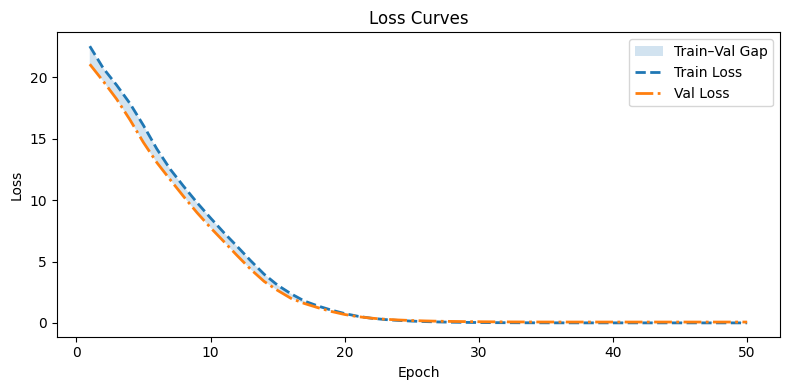

Epoch 50/50 — Train: 0.0040, Val: 0.0728

Train Eval → MSE=0.004082 (Δ +99.59%), QLIKE=0.000367 (Δ +99.96%)


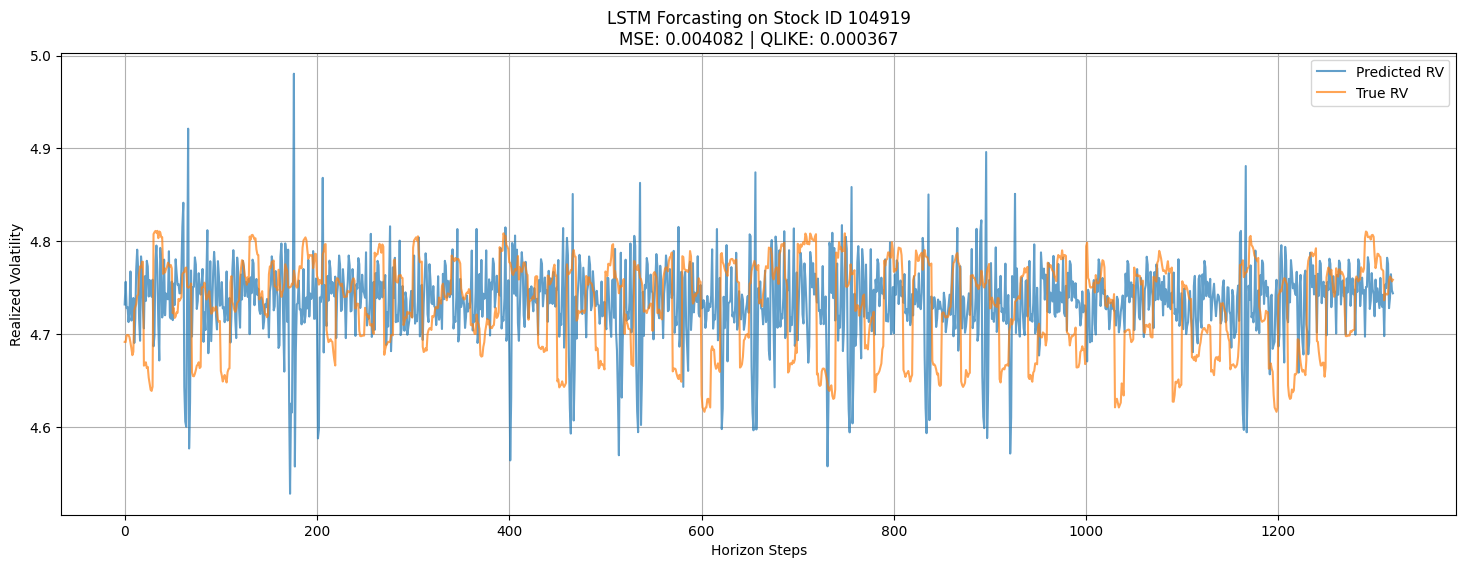

In [16]:
baseline_metrics = {'mse': 1, 'ql': 1}
exp = runModel(
    data,
    window_size=330,
    horizon=10,
    stride=5,
    batch_size=64,
    val_frac=0.2,
    hidden_dim=128,
    num_layers=1,
    lr=1e-3,
    epochs=50,
    dropout=0.0,
    baseline=baseline_metrics,
    device='cuda'
)
model, train_losses, val_losses, mse, ql = exp.run()

## Tuned

No improvement for 10 epochs → stopping early


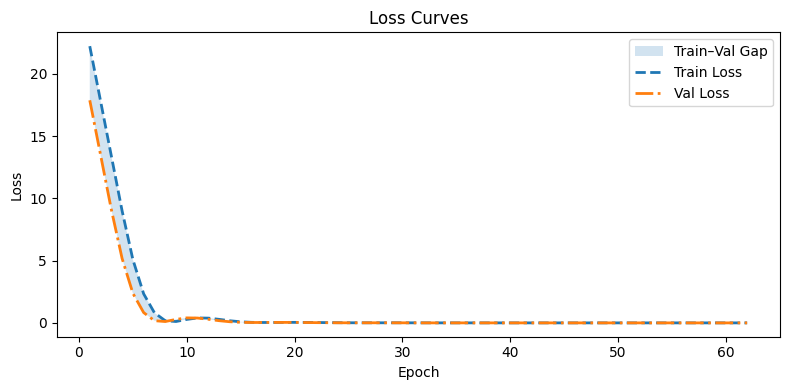

Epoch 62/100 — Train: 0.0024, Val: 0.0022

Train Eval → MSE=0.002418 (Δ +0.00%), QLIKE=0.000217 (Δ +0.00%)


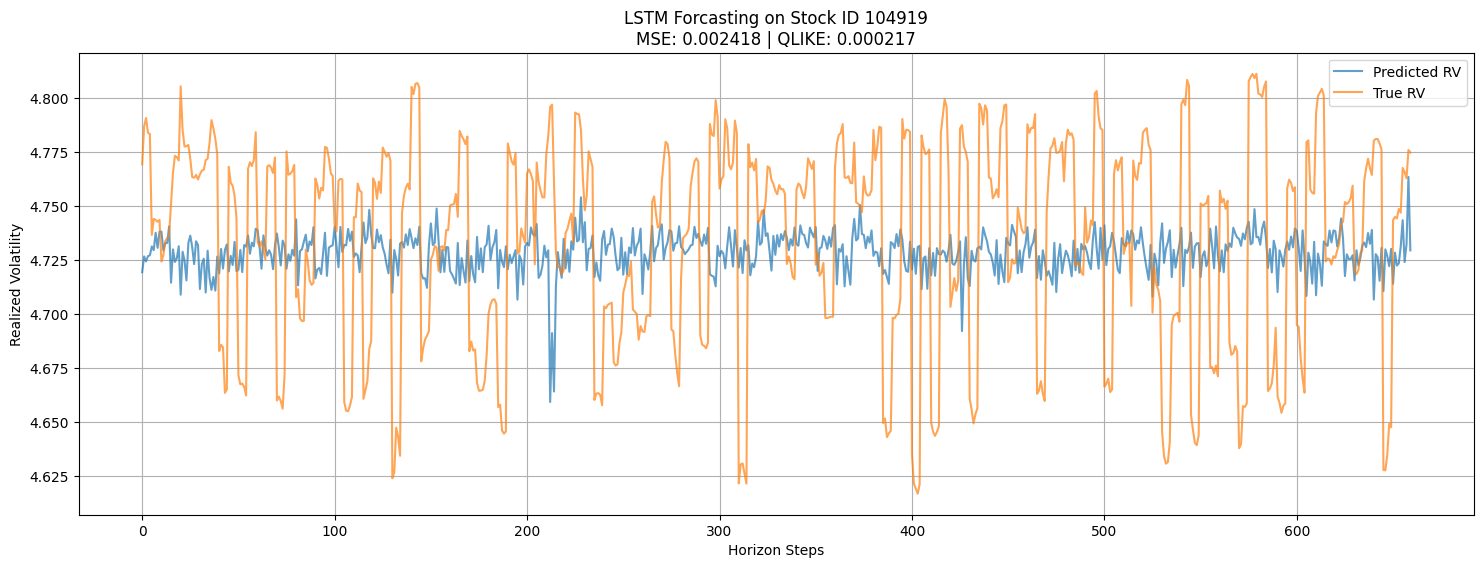

Best hyperparameters: {'window_size': 330, 'horizon': 5, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.0, 'lr': 0.001, 'batch_size': 128}
Best QLIKE: 0.000217


In [20]:
from itertools import product
from torch.optim.lr_scheduler import ReduceLROnPlateau

# define your search space
param_grid = {
    'window_size': [330],
    'horizon':    [5],
    'hidden_dim': [128],
    'num_layers': [2],
    'dropout':    [0.0],
    'lr':         [1e-3],
    'batch_size': [128]
}

best_score = float('inf')
best_params = None

for combo in product(*param_grid.values()):
    cfg = dict(zip(param_grid.keys(), combo))

    exp = runModel(
        df=data,
        window_size=cfg['window_size'],
        horizon=cfg['horizon'],
        stride=5,
        batch_size=cfg['batch_size'],
        val_frac=0.2,
        hidden_dim=cfg['hidden_dim'],
        num_layers=cfg['num_layers'],
        lr=cfg['lr'],
        epochs=100,
        dropout=cfg['dropout'],
        baseline={'mse': float('inf'), 'ql': float('inf')},
        device='cuda',
        scheduler_fn=lambda opt: ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5),
        early_stopping_patience=10,
        verbose=True   
    )

    # run training & evaluation
    _, _, _, mse, ql = exp.run()

    # update best
    if ql < best_score:
        best_score = ql
        best_params = cfg

# final reporting
print("Best hyperparameters:", best_params)
print(f"Best QLIKE: {best_score:.6f}")


# --------------------------------------------

# ARMA-GARCH

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# -----------------------------------------------------------------------------
# Compute realized volatility per time_id
# -----------------------------------------------------------------------------

def realized_volatility(series: pd.Series) -> float:
    """ √(∑(Δlog price)² ) """
    lr = np.diff(np.log(series))
    return np.sqrt(np.sum(lr**2))


def build_volatility_df(feature_df: pd.DataFrame,
                        time_ref_df: pd.DataFrame,
                        stock_id: int) -> pd.DataFrame:
    # filter one stock
    df = feature_df[feature_df['stock_id']==stock_id].copy()
    
    # merge datetime
    df = df.drop(columns=['datetime'], errors='ignore')
    df = df.merge(time_ref_df[['time_id','datetime']], on='time_id', how='left')
    
    # aggregate features per time_id
    agg = df.groupby('time_id').agg({
        'wap':['mean','std'],
        'spread_pct':['mean','std'],
        'spread_variation':['mean','std'],
        'imbalance':['mean','std'],
        'depth_ratio':['mean','std']
    })
    agg.columns = ['_'.join(c) for c in agg.columns]
    agg = agg.reset_index()
    
    # realized volatility
    rv = df.groupby('time_id')['wap'].apply(realized_volatility).reset_index()
    rv.columns = ['time_id','rv']
    
    # merge & sort
    data = agg.merge(rv, on='time_id', how='inner')
    return data.sort_values('time_id').reset_index(drop=True)


# -----------------------------------------------------------------------------
# Stationarity & ARCH tests
# -----------------------------------------------------------------------------
def check_stationarity_and_arch(series: pd.Series, verbose=True):
    clean = series.dropna()
    adf_p = adfuller(clean)[1]
    lm_stat, arch_p, _, _ = het_arch(clean)
    if verbose:
        print(f"ADF p-value: {adf_p:.4f} → {'stationary' if adf_p<0.05 else 'non-stationary'}")
        print(f"ARCH p-value: {arch_p:.4f} → {'ARCH effects present' if arch_p<0.05 else 'no ARCH'}")


In [ ]:
# -----------------------------------------------------------------------------
# Select ARMA(p,q) by AIC
# -----------------------------------------------------------------------------
def select_arma_order(series: pd.Series, p_max=3, q_max=3):
    best_aic = np.inf
    best_order = (0,0)
    for p in range(p_max+1):
        for q in range(q_max+1):
            try:
                m = ARIMA(series, order=(p,0,q)).fit()
                if m.aic < best_aic:
                    best_aic, best_order = m.aic, (p,q)
            except Exception:
                continue
    return best_order


# -----------------------------------------------------------------------------
# Rolling‐window ARMA–GARCH forecast
# -----------------------------------------------------------------------------
def rolling_arma_garch_forecast(
    rv_series: pd.Series,
    train_frac: float = 0.8,
    arma_order: tuple[int,int] = (1,1),
    garch_p: int = 1,
    garch_q: int = 1,
    dist: str = 't'
) -> pd.DataFrame:
    
    ids   = rv_series.index
    split = int(len(ids) * train_frac)

    preds, actuals, out_idx = [], [], []
    eps = 1e-6   # clip floor to avoid log(0)

    for i in range(split, len(ids)):
        train_ids = ids[i - split : i]
        test_id   = ids[i]

        # clip zeros & negative before logging
        rv_clip = rv_series.loc[train_ids].clip(lower=eps)
        y_train = np.log(rv_clip)
        y_true  = rv_series.loc[test_id]

        try:
            # fit ARX + GARCH with no automatic rescaling
            am = arch_model(
                y_train,
                mean='ARX', lags=arma_order[0],
                vol='Garch', p=garch_p, q=garch_q,
                dist=dist,
                rescale=False
            )
            res = am.fit(disp='off')

            # 1‐step ahead forecast of log‐RV
            f = res.forecast(horizon=1)
            mu = f.mean.iloc[-1, 0]
            rv_pred = np.exp(mu)

            # skip non‐finite
            if not (np.isfinite(rv_pred) and np.isfinite(y_true)):
                continue

            preds.append(rv_pred)
            actuals.append(y_true)
            out_idx.append(test_id)

        except Exception:
            # skip windows where fitting fails
            continue

    return pd.DataFrame({
        'forecast_vol': preds,
        'realized_vol': actuals
    }, index=out_idx)



# -----------------------------------------------------------------------------
# Metrics & plotting
# -----------------------------------------------------------------------------
def qlike(actual: np.ndarray, forecast: np.ndarray) -> float:
    v_a = actual**2
    v_f = forecast**2
    return np.mean(v_a/v_f - np.log(v_a/v_f) - 1)


def evaluate_and_plot(df_roll: pd.DataFrame, window_size: int, arma_order: tuple[int,int], garch_p: int, garch_q: int):
    # 1) drop infinities / NaNs
    df = (
        df_roll
        .replace([np.inf, -np.inf], np.nan)
        .dropna(subset=['forecast_vol','realized_vol'])
    )
    if df.empty:
        print("No valid forecasts to evaluate.")
        return

    # 2) metrics
    mse_val = mean_squared_error(df['realized_vol'], df['forecast_vol'])
    def qlike(a,f,eps=1e-8):
        va = np.maximum(a**2, eps)
        vf = np.maximum(f**2, eps)
        return np.mean(va/vf - np.log(va/vf) - 1)
    ql_val = qlike(df['realized_vol'].values, df['forecast_vol'].values)

    print(f"MSE:   {mse_val:.6e}")
    print(f"QLIKE: {ql_val:.6e}")

    # 3) plot
    plt.figure(figsize=(12,4))
    plt.plot(df.index, df['realized_vol'],  label='Realized Vol')
    plt.plot(df.index, df['forecast_vol'], label='Forecast Vol', alpha=0.8)
    plt.title(f"ARMA{arma_order}–GARCH({garch_p},{garch_q}) Rolling Forecast (window={window_size})")
    plt.xlabel("Time ID")
    plt.ylabel("Volatility")
    plt.legend()
    plt.grid(True)
    plt.show()

In [114]:
data

,time_id,wap_mean,wap_std,spread_pct_mean,spread_pct_std,spread_variation_mean,spread_variation_std,imbalance_mean,imbalance_std,depth_ratio_mean,depth_ratio_std,rv
0,6,312.842155,0.829877,0.000060,0.000021,0.000015,0.000006,-0.162534,0.611273,4.313373,23.581804,4.807008
1,7,309.231075,0.475406,0.000065,0.000022,0.000017,0.000006,0.087924,0.496253,5.686755,50.353588,4.809500
2,8,306.442402,0.401315,0.000087,0.000023,0.000019,0.000008,-0.023225,0.576379,6.748583,48.360719,4.803505
3,9,308.495538,0.258728,0.000070,0.000023,0.000018,0.000007,0.027171,0.575943,20.388999,115.731741,4.806796
4,10,307.963284,0.324486,0.000075,0.000021,0.000016,0.000008,0.053510,0.566920,6.955926,53.476087,4.805533
...,...,...,...,...,...,...,...,...,...,...,...,...
1153,1195,365.130518,0.259646,0.000034,0.000012,0.000010,0.000004,-0.103674,0.569284,11.171572,113.452049,4.774629
1154,1196,365.205107,0.170992,0.000035,0.000012,0.000011,0.000004,-0.053523,0.595237,9.453509,83.006676,4.776324
1155,1197,365.059585,0.120159,0.000034,0.000012,0.000010,0.000005,-0.045034,0.615636,14.635871,122.913062,4.775886
1156,1198,364.197732,0.269801,0.000035,0.000012,0.000011,0.000004,0.004308,0.615099,8.206035,86.571075,4.785591


ADF p-value: 0.0769 → non-stationary
ARCH p-value: 0.0000 → ARCH effects present


c:\Users\dungh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dungh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dungh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dungh\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.war

Selected ARMA order by AIC: (1, 1)


c:\Users\dungh\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\dungh\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\dungh\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\dungh\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequal

MSE:   2.344201e+127
QLIKE: 5.964490e+07


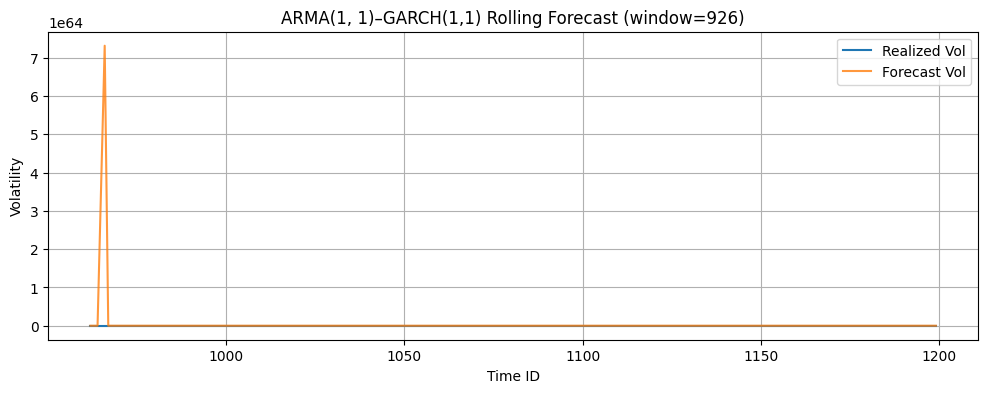

In [122]:
# Stationarity & ARCH tests on raw RV
check_stationarity_and_arch(data['rv'])

# Select ARMA order
best_p, best_q = select_arma_order(np.log(data['rv']), p_max=3, q_max=3)
print("Selected ARMA order by AIC:", (best_p, best_q))

# Rolling‐window forecast
df_roll = rolling_arma_garch_forecast(
    rv_series  = data.set_index('time_id')['rv'],
    train_frac = 0.8,
    arma_order = (best_p, best_q),
    garch_p    = 1,
    garch_q    = 1,
    dist       = 't'
)

# Evaluate & plot
evaluate_and_plot(df_roll, window_size=int(len(data)*0.8), 
                  arma_order=(best_p, best_q), garch_p=1, garch_q=1)